## Parâmetros de treinamento

* **Pontos de colocação por época (amostragem uniforme):**

  * **Domínio (PDE):** **4.000**
  * **Contorno – Dirichlet (engastes):**

    * $x=0$**:** **2.000**
    * $y=0$**:** **2.000**
  * **Contorno – Neumann (lados livres):**

    * $x=L$: $\sigma_{xx}=1$**:** **2.000**
    * $\sigma_{xy}=0$ em $x=L$ **e** $y=L$: **1.500** cada (total **3.000**)
    * $y=L$: $\sigma_{yy}=0$**:** **2.000**
  * **Avaliação (plots):** **10.000** pontos (grade 100×100)
* **Função de ativação:** `Tanh`
* **Otimizadores:** **Adam** (`lr = 1e-3`, **2.500** épocas) → **L-BFGS** (`max_iter = 500`, `strong_wolfe`) para refinamento
* **Material (plano de tensão):** $E=1.0$, $\nu=0.3$; $\mu=\dfrac{E}{2(1+\nu)}$, $\lambda=\dfrac{2\mu\nu}{1-\nu}=\dfrac{E\nu}{1-\nu^2}$

## Estrutura da rede (FNN)

* **Camadas:** **2–30–30–30–2**

  * **Entrada:** 2 nós $(x,y)$
  * **Ocultas:** 3 camadas com **30 neurônios** cada (`tanh`)
  * **Saída:** 2 nós $(u_x,u_y)$
* **Inicialização:** Xavier/Glorot uniforme
* **Parâmetros treináveis:** \~**2.012**

## Condições de contorno

* **Engastes — $x=0$ e $y=0$:** $u_x=0,\ u_y=0$ (**soft**, via termos de perda `clamp_left_loss` e `clamp_bottom_loss`)
* **Lado direito — $x=L$:** $\sigma_{xx}=1$ (**soft**, `traction_right_loss`) **e** $\sigma_{xy}=0$ (**soft**, parte de `shear_free_right_top_loss`)
* **Topo — $y=L$:** $\sigma_{yy}=0$ e $\sigma_{xy}=0$ (**soft**, `top_free_sigma_yy_loss` + `shear_free_right_top_loss`)
* **Observação:** o enunciado pede $\sigma_{xy}=0$ **em todo o contorno**. No código atual, isso está imposto em **$x=L$** e **$y=L$**; se quiser cumprir literalmente também em **$x=0$** e **$y=0$**, basta adicionar um termo extra de perda para $\sigma_{xy}=0$ nessas duas bordas (posso te passar o patch quando quiser).

## Resultados (qualitativos)

* **Deslocamento $u_x$:** cresce em direção a $x=L$, com valores máximos próximos ao lado carregado e variação suave no interior (tração uniforme $\sigma_{xx}=1$).
* **Deslocamento $u_y$:** padrão compatível com o efeito de Poisson (contração vertical predominante onde a placa é “esticada” em $x$).
* **Curva de perda (Total):** queda monotônica em escala log durante o Adam; L-BFGS refina e estabiliza a solução.

[Adam]    0  loss=8.6567e+00
[Adam]  100  loss=2.1004e+00
[Adam]  200  loss=1.1121e+00
[Adam]  300  loss=7.9671e-01
[Adam]  400  loss=5.5755e-01
[Adam]  500  loss=4.6762e-01
[Adam]  600  loss=4.2675e-01
[Adam]  700  loss=3.9951e-01
[Adam]  800  loss=3.6324e-01
[Adam]  900  loss=3.3340e-01
[Adam] 1000  loss=2.9443e-01
[Adam] 1100  loss=2.8876e-01
[Adam] 1200  loss=2.7442e-01
[Adam] 1300  loss=2.5342e-01
[Adam] 1400  loss=2.4513e-01
[Adam] 1500  loss=2.4078e-01
[Adam] 1600  loss=2.1286e-01
[Adam] 1700  loss=2.1770e-01
[Adam] 1800  loss=2.0864e-01
[Adam] 1900  loss=1.8721e-01
[Adam] 2000  loss=1.8113e-01
[Adam] 2100  loss=1.7190e-01
[Adam] 2200  loss=1.6089e-01
[Adam] 2300  loss=1.5820e-01
[Adam] 2400  loss=1.5158e-01

[LBFGS] Refinando...


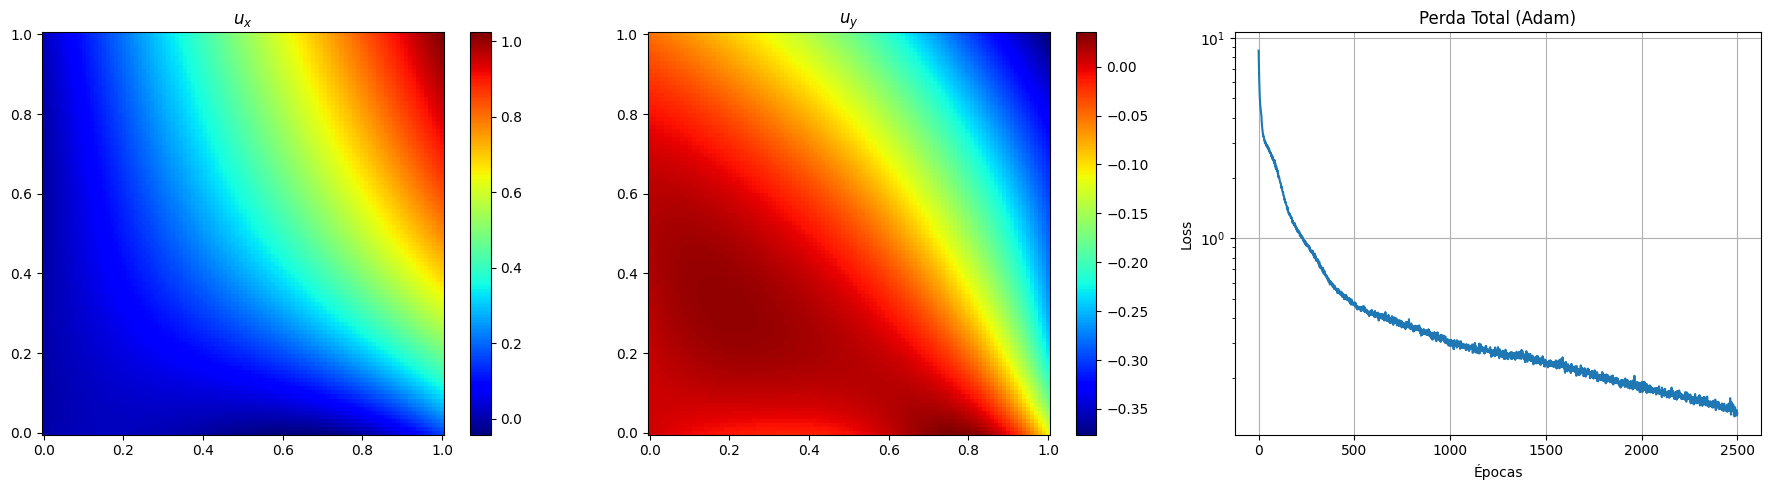

In [3]:
# PINN – Placa 2D
# Engaste em x=0 e y=0; lado direito com sigma_xx(L,y)=1;
# topo livre: sigma_yy(x,L)=0 e sigma_xy(x,L)=0;
# e sigma_xy(L,y)=0 no lado direito (cisalhamento nulo no contorno livre)

import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Configs ----------------
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L = 1.0
E, nu = 1.0, 0.3
# Plano de tensão:
mu = E/(2*(1+nu))
lambda_ = 2*mu*nu/(1-nu)   # = E*nu/(1-nu**2)

# ---------------- Rede -------------------
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.act = nn.Tanh()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1])
                                     for i in range(len(layers)-1)])
        # Xavier
        for i,lin in enumerate(self.layers):
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.act(self.layers[i](x))
        return self.layers[-1](x)

model = PINN([2, 30, 30, 30, 2]).to(device)

# ---------------- Util -------------------
def grads_u(model, xy):
    """Retorna ux, uy e seus gradientes em relação a x,y"""
    u = model(xy)
    ux, uy = u[:, :1], u[:, 1:]
    g_ux = autograd.grad(ux, xy, torch.ones_like(ux), create_graph=True)[0]
    g_uy = autograd.grad(uy, xy, torch.ones_like(uy), create_graph=True)[0]
    u_xx, u_xy = g_ux[:, :1], g_ux[:, 1:2]
    u_yx, u_yy = g_uy[:, :1], g_uy[:, 1:2]
    return ux, uy, u_xx, u_xy, u_yx, u_yy

def sigmas_from_grads(u_xx, u_xy, u_yx, u_yy):
    exx, eyy = u_xx, u_yy
    sxx = lambda_*(exx+eyy) + 2*mu*exx
    syy = lambda_*(exx+eyy) + 2*mu*eyy
    sxy = mu*(u_xy + u_yx)
    return sxx, syy, sxy

# ---------------- PDE (equilíbrio) ------
def pde_loss(n_int=4000):
    xy = torch.rand((n_int,2), device=device, requires_grad=True) * L
    ux, uy, u_xx, u_xy, u_yx, u_yy = grads_u(model, xy)
    sxx, syy, sxy = sigmas_from_grads(u_xx, u_xy, u_yx, u_yy)

    gsxx = autograd.grad(sxx, xy, torch.ones_like(sxx), create_graph=True)[0]
    gsyy = autograd.grad(syy, xy, torch.ones_like(syy), create_graph=True)[0]
    gsxy = autograd.grad(sxy, xy, torch.ones_like(sxy), create_graph=True)[0]

    fx = gsxx[:, :1] + gsxy[:, 1:2]
    fy = gsxy[:, :1] + gsyy[:, 1:2]
    return (fx.pow(2).mean() + fy.pow(2).mean())

# ---------------- BCs Dirichlet ----------
def clamp_left_loss(n=2000):
    # x=0, 0<=y<=L -> ux=0, uy=0
    y = torch.rand((n,1), device=device)*L
    x = torch.zeros_like(y)
    xy = torch.cat([x,y],dim=1).requires_grad_(False)
    u = model(xy)
    return (u**2).mean()

def clamp_bottom_loss(n=2000):
    # y=0, 0<=x<=L -> ux=0, uy=0
    x = torch.rand((n,1), device=device)*L
    y = torch.zeros_like(x)
    xy = torch.cat([x,y],dim=1).requires_grad_(False)
    u = model(xy)
    return (u**2).mean()

# ---------------- BCs Neumann ------------
def traction_right_loss(n=2000):
    # x=L, sigma_xx=1 (prescrito)
    y = torch.rand((n,1), device=device)*L
    x = torch.ones_like(y)*L
    xy = torch.cat([x,y],dim=1).requires_grad_(True)

    ux, uy, u_xx, u_xy, u_yx, u_yy = grads_u(model, xy)
    sxx, syy, sxy = sigmas_from_grads(u_xx, u_xy, u_yx, u_yy)
    return (sxx - 1.0).pow(2).mean()

def shear_free_right_top_loss(n_each=1500):
    # sigma_xy=0 em x=L (lado direito livre)
    y = torch.rand((n_each,1), device=device)*L
    x = torch.ones_like(y)*L
    xy = torch.cat([x,y],dim=1).requires_grad_(True)
    _,_, u_xx,u_xy,u_yx,u_yy = grads_u(model, xy)
    _,_, sxy_r = sigmas_from_grads(u_xx,u_xy,u_yx,u_yy)

    # sigma_xy=0 no topo y=L
    x2 = torch.rand((n_each,1), device=device)*L
    y2 = torch.ones_like(x2)*L
    xy2 = torch.cat([x2,y2],dim=1).requires_grad_(True)
    _,_, u_xx2,u_xy2,u_yx2,u_yy2 = grads_u(model, xy2)
    _,_, sxy_t = sigmas_from_grads(u_xx2,u_xy2,u_yx2,u_yy2)

    return sxy_r.pow(2).mean() + sxy_t.pow(2).mean()

def top_free_sigma_yy_loss(n=2000):
    # y=L, sigma_yy=0
    x = torch.rand((n,1), device=device)*L
    y = torch.ones_like(x)*L
    xy = torch.cat([x,y],dim=1).requires_grad_(True)

    _,_, u_xx,u_xy,u_yx,u_yy = grads_u(model, xy)
    sxx, syy, sxy = sigmas_from_grads(u_xx,u_xy,u_yx,u_yy)
    return syy.pow(2).mean()

# ---------------- Loss total -------------
def total_loss():
    w_pde = 1.0
    w_clamp = 50.0
    w_trac = 10.0
    w_free = 10.0

    return (
        w_pde * pde_loss()
        + w_clamp*(clamp_left_loss()+clamp_bottom_loss())
        + w_trac*traction_right_loss()
        + w_free*(shear_free_right_top_loss()+top_free_sigma_yy_loss())
    )

# ---------------- Treinamento -----------
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2500
hist = []

for ep in range(epochs):
    opt.zero_grad()
    loss = total_loss()
    loss.backward()
    opt.step()
    hist.append(loss.item())
    if ep % 100 == 0:
        print(f"[Adam] {ep:4d}  loss={loss.item():.4e}")

# Refinamento L-BFGS
def closure():
    opt_lbfgs.zero_grad()
    l = total_loss()
    l.backward()
    return l

opt_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-9, line_search_fn='strong_wolfe')
print("\n[LBFGS] Refinando...")
opt_lbfgs.step(closure)

# ---------------- Visualização ----------
with torch.no_grad():
    xg = torch.linspace(0,L,100, device=device)
    yg = torch.linspace(0,L,100, device=device)
    X,Y = torch.meshgrid(xg, yg, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    U = model(XY)
Ux = U[:,0].reshape(100,100).cpu().numpy()
Uy = U[:,1].reshape(100,100).cpu().numpy()
xx = X.cpu().numpy(); yy = Y.cpu().numpy()

fig, ax = plt.subplots(1,3, figsize=(18,5))
c1 = ax[0].pcolormesh(xx, yy, Ux, cmap=plt.cm.jet, shading='auto')
fig.colorbar(c1, ax=ax[0]); ax[0].set_title("$u_x$"); ax[0].set_aspect('equal')

c2 = ax[1].pcolormesh(xx, yy, Uy, cmap=plt.cm.jet, shading='auto')
fig.colorbar(c2, ax=ax[1]); ax[1].set_title("$u_y$"); ax[1].set_aspect('equal')

ax[2].plot(hist); ax[2].set_yscale('log'); ax[2].grid(True)
ax[2].set_title("Perda Total (Adam)"); ax[2].set_xlabel("Épocas"); ax[2].set_ylabel("Loss")
plt.tight_layout(); plt.show()


[Adam]    0  loss=1.2453e+01
[Adam]  100  loss=3.7192e+00
[Adam]  200  loss=3.4928e+00
[Adam]  300  loss=3.1677e+00
[Adam]  400  loss=2.8211e+00
[Adam]  500  loss=2.4141e+00
[Adam]  600  loss=2.1624e+00
[Adam]  700  loss=2.0681e+00
[Adam]  800  loss=2.0368e+00
[Adam]  900  loss=1.8816e+00
[Adam] 1000  loss=1.8038e+00
[Adam] 1100  loss=1.7274e+00
[Adam] 1200  loss=1.6431e+00
[Adam] 1300  loss=1.5464e+00
[Adam] 1400  loss=1.6449e+00
[Adam] 1500  loss=1.5926e+00
[Adam] 1600  loss=1.4913e+00
[Adam] 1700  loss=1.5047e+00
[Adam] 1800  loss=1.4664e+00
[Adam] 1900  loss=1.4097e+00
[Adam] 2000  loss=1.3927e+00
[Adam] 2100  loss=1.3590e+00
[Adam] 2200  loss=1.3616e+00
[Adam] 2300  loss=1.4136e+00
[Adam] 2400  loss=1.4351e+00
[Adam] 2500  loss=1.3257e+00
[Adam] 2600  loss=1.3449e+00
[Adam] 2700  loss=1.3505e+00
[Adam] 2800  loss=1.2967e+00
[Adam] 2900  loss=1.2947e+00
[Adam] 3000  loss=1.1840e+00
[Adam] 3100  loss=1.2324e+00
[Adam] 3200  loss=1.3177e+00
[Adam] 3300  loss=1.2787e+00
[Adam] 3400  l

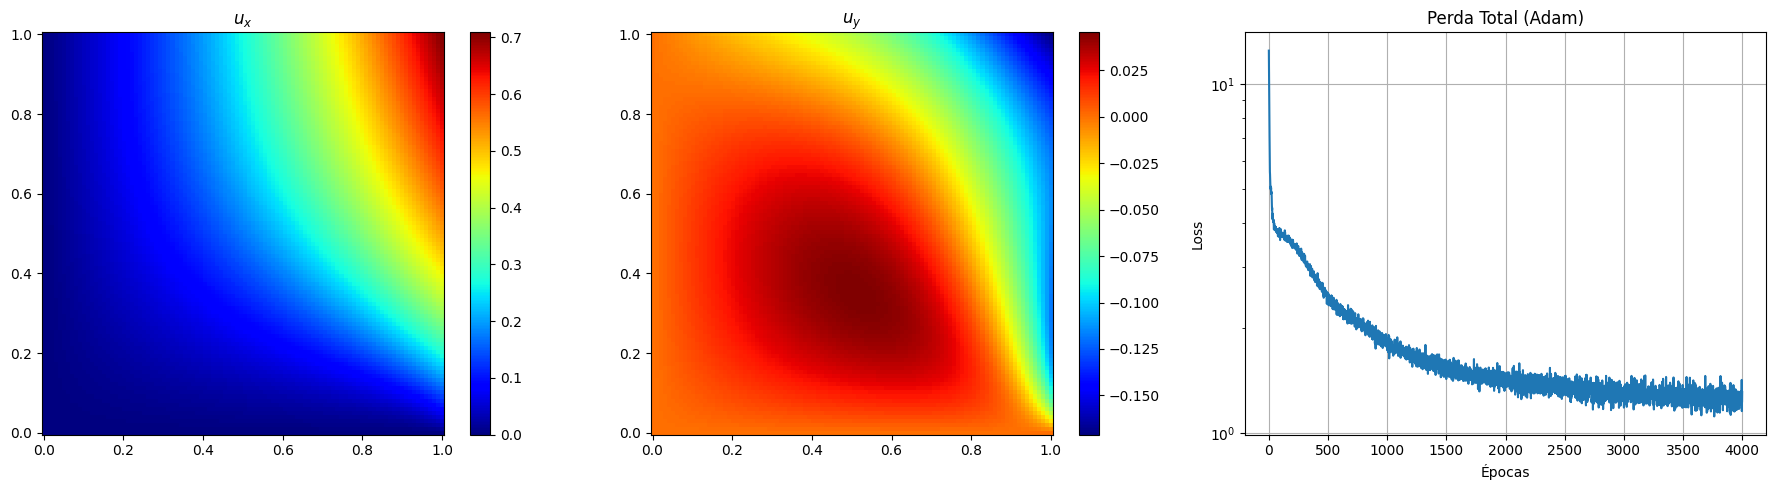

In [6]:
# PINN – Placa 2D (Caso a)
# Engaste: x=0 e y=0  -> ux=0, uy=0  (imposto HARD)
# Direita:  x=L       -> sigma_xx=1, sigma_xy=0
# Topo:     y=L       -> sigma_yy=0, sigma_xy=0
# Modelo: plano de tensão

import torch, torch.nn as nn, torch.autograd as autograd
import numpy as np, matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L = 1.0
E, nu = 1.0, 0.3
mu = E/(2*(1+nu))
lambda_ = 2*mu*nu/(1-nu)   # = E*nu/(1-nu**2)

# ---------------- Rede (BCs de desloc. HARD) ----------------
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.act = nn.Tanh()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1])
                                     for i in range(len(layers)-1)])
        for lin in self.layers:
            nn.init.xavier_uniform_(lin.weight); nn.init.zeros_(lin.bias)

    def core(self, x):
        for i in range(len(self.layers)-1):
            x = self.act(self.layers[i](x))
        return self.layers[-1](x)  # [ux_hat, uy_hat]

    def forward(self, xy):
        # Engaste em x=0 e y=0: zera deslocamentos nessas bordas
        x = xy[:, :1]; y = xy[:, 1:2]
        uhat = self.core(xy)
        ux = x * y * uhat[:, :1]      # ux(0,y)=0 e ux(x,0)=0
        uy = x * y * uhat[:, 1:2]     # uy(0,y)=0 e uy(x,0)=0
        return torch.cat([ux, uy], dim=1)

model = PINN([2, 30, 30, 30, 2]).to(device)

# ---------------- Util -------------------
def stresses_at(xy):
    xy = xy.requires_grad_(True)
    u = model(xy)
    ux, uy = u[:, :1], u[:, 1:]
    gux = autograd.grad(ux, xy, torch.ones_like(ux), create_graph=True)[0]
    guy = autograd.grad(uy, xy, torch.ones_like(uy), create_graph=True)[0]
    exx, exy = gux[:, :1], gux[:, 1:2]
    eyx, eyy = guy[:, :1], guy[:, 1:2]
    sxx = lambda_*(exx+eyy) + 2*mu*exx
    syy = lambda_*(exx+eyy) + 2*mu*eyy
    sxy = mu*(exy+eyx)
    return sxx, syy, sxy

# ---------------- PDE (equilíbrio) ------
def pde_loss(n_int=4000):
    xy = torch.rand((n_int,2), device=device, requires_grad=True) * L
    sxx, syy, sxy = stresses_at(xy)
    gsxx = autograd.grad(sxx, xy, torch.ones_like(sxx), create_graph=True)[0]
    gsyy = autograd.grad(syy, xy, torch.ones_like(syy), create_graph=True)[0]
    gsxy = autograd.grad(sxy, xy, torch.ones_like(sxy), create_graph=True)[0]
    fx = gsxx[:, :1] + gsxy[:, 1:2]
    fy = gsxy[:, :1] + gsyy[:, 1:2]
    return (fx.pow(2).mean() + fy.pow(2).mean())

def shear_zero_left_bottom_loss(n=2000):
    # x = 0, 0<=y<=L
    y = torch.rand((n,1), device=device)*L
    x = torch.zeros_like(y)
    xy_left = torch.cat([x,y], dim=1)
    _, _, sxy_left = stresses_at(xy_left)

    # y = 0, 0<=x<=L
    x2 = torch.rand((n,1), device=device)*L
    y2 = torch.zeros_like(x2)
    xy_bot = torch.cat([x2,y2], dim=1)
    _, _, sxy_bot = stresses_at(xy_bot)

    return sxy_left.pow(2).mean() + sxy_bot.pow(2).mean()


# ---------------- BCs Neumann ------------
def right_traction_loss(n=3000):
    # x=L: sigma_xx = 1 e sigma_xy = 0
    y = torch.rand((n,1), device=device)*L
    x = torch.ones_like(y)*L
    xy = torch.cat([x,y],dim=1)
    sxx, _, sxy = stresses_at(xy)
    return (sxx-1.0).pow(2).mean() + sxy.pow(2).mean()

def top_free_loss(n=3000):
    # y=L: sigma_yy = 0 e sigma_xy = 0
    x = torch.rand((n,1), device=device)*L
    y = torch.ones_like(x)*L
    xy = torch.cat([x,y],dim=1)
    _, syy, sxy = stresses_at(xy)
    return syy.pow(2).mean() + sxy.pow(2).mean()

# ---------------- Loss total -------------
def total_loss():
    w_pde, w_r, w_t, w_lb = 1.0, 15.0, 15.0, 10.0
    return (w_pde*pde_loss()
            + w_r*right_traction_loss()
            + w_t*top_free_loss()
            + w_lb*shear_zero_left_bottom_loss())   # novo termo

# ---------------- Treinamento -----------
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 4000
hist = []
for ep in range(epochs):
    opt.zero_grad()
    loss = total_loss()
    loss.backward()
    opt.step()
    hist.append(loss.item())
    if ep % 100 == 0:
        print(f"[Adam] {ep:4d}  loss={loss.item():.4e}")

# Refinamento L-BFGS
def closure():
    opt_lbfgs.zero_grad()
    l = total_loss()
    l.backward()
    return l

opt_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=800,
                              tolerance_grad=1e-8, line_search_fn='strong_wolfe')
print("\n[LBFGS] Refinando...")
final_loss = opt_lbfgs.step(closure).item()
print(f"[LBFGS] loss_final = {final_loss:.4e}")

# ---------------- Visualização ----------
with torch.no_grad():
    xg = torch.linspace(0,L,100, device=device)
    yg = torch.linspace(0,L,100, device=device)
    X,Y = torch.meshgrid(xg, yg, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    U = model(XY)
Ux = U[:,0].reshape(100,100).cpu().numpy()
Uy = U[:,1].reshape(100,100).cpu().numpy()
xx = X.cpu().numpy(); yy = Y.cpu().numpy()

fig, ax = plt.subplots(1,3, figsize=(18,5))
c1 = ax[0].pcolormesh(xx, yy, Ux, cmap=plt.cm.jet, shading='auto'); fig.colorbar(c1, ax=ax[0])
ax[0].set_title("$u_x$"); ax[0].set_aspect('equal')

c2 = ax[1].pcolormesh(xx, yy, Uy, cmap=plt.cm.jet, shading='auto'); fig.colorbar(c2, ax=ax[1])
ax[1].set_title("$u_y$"); ax[1].set_aspect('equal')

ax[2].plot(hist); ax[2].set_yscale('log'); ax[2].grid(True)
ax[2].set_title("Perda Total (Adam)"); ax[2].set_xlabel("Épocas"); ax[2].set_ylabel("Loss")
plt.tight_layout(); plt.show()

@torch.no_grad()
def check_residuos_a(n=5000):
    def meanabs(t): return t.abs().mean().item()
    def rms(t): return t.pow(2).mean().sqrt().item()

    # --- Lado direito x=L: sxx≈1 e sxy≈0
    y = torch.rand((n,1), device=device)*L; x = torch.ones_like(y)*L
    sxx, _, sxy = stresses_at(torch.cat([x,y],1))
    r_right_sxx = meanabs(sxx - 1.0)
    r_right_sxy = meanabs(sxy)

    # --- Topo y=L: syy≈0 e sxy≈0
    x = torch.rand((n,1), device=device)*L; y = torch.ones_like(x)*L
    _, syy, sxy = stresses_at(torch.cat([x,y],1))
    r_top_syy = meanabs(syy); r_top_sxy = meanabs(sxy)

    # --- Base y=0 e Esquerda x=0: sxy≈0 (se você impôs "em todo contorno")
    x = torch.rand((n,1), device=device)*L; y = torch.zeros_like(x)
    _, _, sxy_b = stresses_at(torch.cat([x,y],1))
    y = torch.rand((n,1), device=device)*L; x = torch.zeros_like(y)
    _, _, sxy_l = stresses_at(torch.cat([x,y],1))

    # --- Engaste (hard): <|u|> deve ser ~0
    u_left  = model(torch.cat([torch.zeros((n,1),device=device), torch.rand((n,1),device=device)*L],1))
    u_bot   = model(torch.cat([torch.rand((n,1),device=device)*L, torch.zeros((n,1),device=device)],1))
    r_left_u = meanabs(u_left); r_bot_u = meanabs(u_bot)

    # --- Equilíbrio interno: RMS(div σ)
    xy = torch.rand((n,2), device=device, requires_grad=True)*L
    sxx, syy, sxy = stresses_at(xy)
    gsxx = autograd.grad(sxx, xy, torch.ones_like(sxx), create_graph=True)[0]
    gsyy = autograd.grad(syy, xy, torch.ones_like(syy), create_graph=True)[0]
    gsxy = autograd.grad(sxy, xy, torch.ones_like(sxy), create_graph=True)[0]
    fx = gsxx[:, :1] + gsxy[:, 1:2]
    fy = gsxy[:, :1] + gsyy[:, 1:2]
    r_pde = rms(fx) + rms(fy)

    print("\n=== Resíduos médios ===")
    print(f"x=L:  <|σxx-1|> = {r_right_sxx:.3e}   <|σxy|> = {r_right_sxy:.3e}")
    print(f"y=L:  <|σyy|>   = {r_top_syy:.3e}   <|σxy|> = {r_top_sxy:.3e}")
    print(f"y=0:  <|σxy|>   = {meanabs(sxy_b):.3e}")
    print(f"x=0:  <|σxy|>   = {meanabs(sxy_l):.3e}")
    print(f"x=0:  <|u|>     = {r_left_u:.3e}    y=0: <|u|> = {r_bot_u:.3e}")
    print(f"Ω:     RMS(div σ) ≈ {r_pde:.3e}")

